# Choosing parameters values on train data

In [1]:
%matplotlib inline

# import modules & set up logging
import gensim, logging
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn import metrics

import progressbar

In [140]:
input_file = '../data/input/tweets-vec.csv'
MA_WIDTH = 20
HOT_THRESHOLD = 2.5

In [ ]:
df = pd.read_csv(input_file)
print('Total {} tweets'.format(len(df)))

In [3]:
# Convert to datetime
df['dt'] = pd.to_datetime(df.created_at)

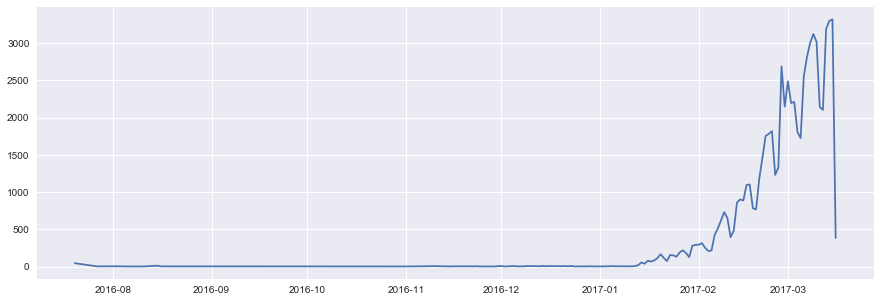

In [4]:
grouped_day = df.groupby(df['dt'].map(lambda x: x.date()))
tweets_per_day = grouped_day.dt.count()
plt.figure(figsize=(15,5))
plt.plot(tweets_per_day)

## Restore list of numbers in vectors

In [33]:
# np.fromstring(df.avg_vector[0].split())
vector_temp = df.avg_vector.apply(lambda x: x.strip('[ ]').split())
# aa = df.avg_vector[0].strip('[ ]').split()

In [34]:
vector_float = vector_temp.apply(lambda x: [np.float(elem) for elem in x])

In [35]:
df['avg_vector'] = vector_float

In [36]:
df.head()

,created_at,favorite_count,id,lang,retweet_count,text,user,sentences,avg_vector,dt
0,Thu Mar 16 04:16:07 +0000 2017,76.0,842227957863223297,en,39.0,The world's oldest golf club is now open to wo...,807095,"['world', 'oldest', 'golf', 'club', 'open', 'w...","[-0.0739397332, -0.00617327029, 0.0933314711, ...",2017-03-16 04:16:07
1,Thu Mar 16 04:04:04 +0000 2017,67.0,842224924227964929,en,30.0,"""They call it dangerous and against Islam. But...",807095,"['call', 'dangerous', 'islam', 'neighbors', 'y...","[0.0388870239, 0.00826263428, 0.128723145, 0.0...",2017-03-16 04:04:04
2,Thu Mar 16 03:52:02 +0000 2017,190.0,842221896682860546,en,76.0,The Fed seems to believe that after nearly 8 y...,807095,"['fed', 'seems', 'believe', 'nearly', 'years',...","[0.05914307, 0.05874125, -0.02457682, 0.071395...",2017-03-16 03:52:02
3,Thu Mar 16 03:40:05 +0000 2017,NaN,842218887294918657,en,23.0,RT @MichaelPaulson: One more photo from @wecom...,807095,"['michaelpaulson', 'one', 'photo', 'wecomefrom...","[-0.0614624023, 0.044128418, 0.0120849609, 0.0...",2017-03-16 03:40:05
4,Thu Mar 16 03:35:02 +0000 2017,54.0,842217618723508224,en,26.0,Is your NCAA knowledge as good as your trash-t...,807095,"['ncaa', 'knowledge', 'good', 'trash', 'talk',...","[-0.0440652, 0.07550049, 0.10559954, 0.0988420...",2017-03-16 03:35:02


## Running clustering on the window

In [37]:
# metric = 'cosine', 'euclidean', ...
def get_clusters(df, n_clusters=20, metric='cosine'):
    X = np.array(df.avg_vector.tolist(), ndmin=2)
    kmeans = KMeans(n_clusters=n_clusters, init='random').fit(X)
    cluster = kmeans.labels_
    silhouette_values = metrics.silhouette_samples(X, kmeans.labels_, metric=metric)
    
    res = pd.DataFrame({'cluster': cluster,
                        'sil_value': silhouette_values},
                        index=df.index)
    return(res)

In [38]:
def get_cluster_order(df, news_min=10, metric='cosine'):
    cluster = df.cluster
    silhouette_values = df.sil_value
    sil_clusters = pd.DataFrame({'cluster': cluster, 'sil': silhouette_values})
    
    grouped = sil_clusters.groupby('cluster')
    col_order_sum = grouped.aggregate({'sil': {sum, 'count'}})['sil']. \
                    sort_values(by='sum', ascending=False)
    col_order_sum = col_order_sum[col_order_sum['count'] >= news_min]
    scores = list(col_order_sum['sum'])
    col_order_sum = list(col_order_sum.index)
    
    res = pd.DataFrame({'cluster': col_order_sum,
                                 'score': scores})
    
    return(res)

In [39]:
df_day = df[(df['dt'] > '2017-03-15 10:00:00') & (df['dt'] < '2017-03-15 12:00:00')]

In [40]:
res = get_clusters(df_day)

In [41]:
df_day_res = pd.concat([df_day, res], axis=1)

In [42]:
df_day_res.head(3)

,created_at,favorite_count,id,lang,retweet_count,text,user,sentences,avg_vector,dt,cluster,sil_value
94,Wed Mar 15 11:50:09 +0000 2017,1053.0,841979829075488770,en,879.0,"By claiming losses, President Trump apparently...",807095,"['claiming', 'losses', 'president', 'trump', '...","[0.07208252, 0.03706243, 0.03948271, 0.0811955...",2017-03-15 11:50:09,9,0.222538
95,Wed Mar 15 11:43:06 +0000 2017,NaN,841978058483617792,en,111.0,"RT @nytimesworld: Disney won't cut the ""gay mo...",807095,"['nytimesworld', 'disney', 'cut', 'gay', 'mome...","[-0.06113942, 0.03198369, 0.01520538, 0.117024...",2017-03-15 11:43:06,6,0.077285
96,Wed Mar 15 11:33:01 +0000 2017,915.0,841975519604273153,en,251.0,"BBC Dad: ""My real life punched through the fak...",807095,"['bbc', 'dad', 'real', 'life', 'punched', 'fak...","[0.0254455563, 0.0235656742, 0.0101806642, 0.0...",2017-03-15 11:33:01,18,-0.151197


In [43]:
cluster_order = get_cluster_order(df_day_res, metric='cosine')

In [44]:
cluster_order[0:3]

,cluster,score
0,9,7.938121
1,7,6.475167
2,19,1.084781


In [144]:
print('Top-3 events this time')
for index, cluster in cluster_order[0:3].iterrows():
    print('Cluster {}, score = {:.1f}'.format(cluster.cluster, cluster.score))
    tweets = df_day_res[df_day_res.cluster == cluster.cluster]. \
            sort_values(by=['sil_value'], ascending=False).head(5).text.tolist()
    print('\n'.join(tweets))
    print('\n')

Top-3 events this time
Cluster 9.0, score = 7.9
ON @GMA: Trump's tax returns leaked; The White House saying he paid $38 million in federal taxes in 2005:? https://t.co/O4twP7rBEo
There?s a theory that those ?leaked? Donald Trump tax returns came from the White House https://t.co/OFMyD9QDo9
RT @GMA: WATCH: Leaked Trump tax return reveals he paid $38 million in federal taxes in 2005: https://t.co/qzuwrRowzw https://t.co/mEactyaq?
Did Trump have his own tax return leaked? That was the big question after Maddow. https://t.co/QMN3JWyiyV
Trump questions the origins of a leaked 2005 tax return that showed he paid $38M on more than $150M reported income? https://t.co/tdNPajRyQ6


Cluster 7.0, score = 6.5
'Marine A' Alexander Blackman's murder conviction downgraded to manslaughter after new evidence comes to light https://t.co/43iUQkGJQQ
#BREAKING: Royal Marine Alexander Blackman has had his murder conviction quashed and reduced to manslaughter? https://t.co/TH0mYMbNxe
Royal Marine Alexander Bl

In [148]:
cluster = cluster_order.head(1)
cluster.cluster[0]

9

In [175]:

print('Cluster {}, score = {:.1f}'.format(cluster.cluster[0], cluster.score[0]))
tweet = df_day_res[df_day_res.cluster == cluster.cluster[0]]. \
        sort_values(by=['sil_value'], ascending=False).head(1)
print(tweet)

Cluster 9, score = 7.9
                           created_at  favorite_count                  id  \
61181  Wed Mar 15 10:52:01 +0000 2017            46.0  841965199905153029   

      lang  retweet_count                                               text  \
61181   en           30.0  ON @GMA: Trump's tax returns leaked; The White...   

           user                                          sentences  \
61181  28785486  ['gma', 'trump', 'tax', 'returns', 'leaked', '...   

                                              avg_vector                  dt  \
61181  [0.0757795051, 0.0311846044, -0.016026089, 0.0... 2017-03-15 10:52:01   

       cluster  sil_value  
61181        9   0.400207  


In [169]:
tweet['text']

KeyError: 1

In [46]:
def get_max_score(df):
    clusters = get_clusters(df)
    cluster_order = get_cluster_order(clusters)
    return(cluster_order.score[0])

In [47]:
len(df_day)

352

In [48]:
get_max_score(df_day)

6.375254017302014

## Rolling window historical

In [49]:
df.head(3)

,created_at,favorite_count,id,lang,retweet_count,text,user,sentences,avg_vector,dt
0,Thu Mar 16 04:16:07 +0000 2017,76.0,842227957863223297,en,39.0,The world's oldest golf club is now open to wo...,807095,"['world', 'oldest', 'golf', 'club', 'open', 'w...","[-0.0739397332, -0.00617327029, 0.0933314711, ...",2017-03-16 04:16:07
1,Thu Mar 16 04:04:04 +0000 2017,67.0,842224924227964929,en,30.0,"""They call it dangerous and against Islam. But...",807095,"['call', 'dangerous', 'islam', 'neighbors', 'y...","[0.0388870239, 0.00826263428, 0.128723145, 0.0...",2017-03-16 04:04:04
2,Thu Mar 16 03:52:02 +0000 2017,190.0,842221896682860546,en,76.0,The Fed seems to believe that after nearly 8 y...,807095,"['fed', 'seems', 'believe', 'nearly', 'years',...","[0.05914307, 0.05874125, -0.02457682, 0.071395...",2017-03-16 03:52:02


In [50]:
df_dt = df.set_index('dt')

In [51]:
df_dt.head(3)

,created_at,favorite_count,id,lang,retweet_count,text,user,sentences,avg_vector
dt,,,,,,,,,
2017-03-16 04:16:07,Thu Mar 16 04:16:07 +0000 2017,76.0,842227957863223297,en,39.0,The world's oldest golf club is now open to wo...,807095,"['world', 'oldest', 'golf', 'club', 'open', 'w...","[-0.0739397332, -0.00617327029, 0.0933314711, ..."
2017-03-16 04:04:04,Thu Mar 16 04:04:04 +0000 2017,67.0,842224924227964929,en,30.0,"""They call it dangerous and against Islam. But...",807095,"['call', 'dangerous', 'islam', 'neighbors', 'y...","[0.0388870239, 0.00826263428, 0.128723145, 0.0..."
2017-03-16 03:52:02,Thu Mar 16 03:52:02 +0000 2017,190.0,842221896682860546,en,76.0,The Fed seems to believe that after nearly 8 y...,807095,"['fed', 'seems', 'believe', 'nearly', 'years',...","[0.05914307, 0.05874125, -0.02457682, 0.071395..."


In [52]:
df1 = df_dt.sort_index()

In [53]:
df2 = df1['2017-03-15 10:00:00':'2017-03-15 12:00:00']


In [54]:
# 'minute_range' is in munites
def setup_intervals(start, end, freq='10min', minute_range=120):
    dt1 = pd.date_range(start, end, freq=freq)
    dt2 = dt1 - pd.Timedelta(minutes=minute_range)
    intervals = pd.DataFrame({'t_from': dt2, 't_to': dt1})
    return(intervals)

In [141]:
intervals = setup_intervals(start='2017-03-15 10:00:00', end='2017-03-16 00:00:00', freq='10min', minute_range=120)

In [151]:
def get_scores(df, intervals):
    bar = progressbar.ProgressBar(max_value=len(intervals)-1)
    scores = list()
    hots = list()
    for index, interval in intervals.iterrows():
        t_from = interval.t_from
        t_to = interval.t_to
        df_interval = df[(df.index >= t_from) & (df.index <= t_to)]
        
        # Clustering, choosing most important cluster
        clusters = get_clusters(df_interval)
        cluster_order = get_cluster_order(clusters)
        score = cluster_order.score[0]
        scores.append(score)
        
        # Detecting hot cluster
        hot = False
        if(len(scores) > MA_WIDTH):
            ma = np.mean(scores[-MA_WIDTH:])
            std = np.std(scores[-MA_WIDTH:])
            if(score > (ma + HOT_THRESHOLD * std)):
                hot = True
                # Record hot tweet
                df_interval_res = pd.concat([df_interval, clusters], axis=1)
                cluster = cluster_order.head(1)
                print('Cluster {}, score = {:.1f}'.format(cluster.cluster[0], cluster.score[0]))
                tweet = df_interval_res[df_interval_res.cluster == cluster.cluster[0]]. \
                        sort_values(by=['sil_value'], ascending=False).head(1).text
                print(tweet)
                print('\n')
        hots.append(hot)
                
        bar.update(index)
    res = pd.DataFrame({'score': scores, 'hot': hots}, index=intervals.index)
    return(res)

In [152]:
scores = get_scores(df_dt, intervals)

 45% (38 of 84) |##########################################                                                     | Elapsed Time: 0:00:07 ETA: 0:00:08

Cluster 14, score = 10.4
dt
2017-03-15 16:04:37    US charges two Russian spies and two hackers i...
Name: text, dtype: object




 96% (81 of 84) |###########################################################################################    | Elapsed Time: 0:00:14 ETA: 0:00:00

Cluster 9, score = 13.3
dt
2017-03-15 21:48:36    Federal judge in Hawaii to rule on Trump trave...
Name: text, dtype: object


Cluster 1, score = 14.4
dt
2017-03-15 21:48:36    Federal judge in Hawaii to rule on Trump trave...
Name: text, dtype: object




100% (84 of 84) |##############################################################################################| Elapsed Time: 0:00:14 ETA:  0:00:00

In [75]:
scores.hot.sum()

0

In [134]:
a_f = lambda feature: scores[feature]
ma_f = lambda feature, lag: a_f(feature).rolling(window=lag).mean()
mstd_f = lambda feature, lag: a_f(feature).rolling(window=lag).std()

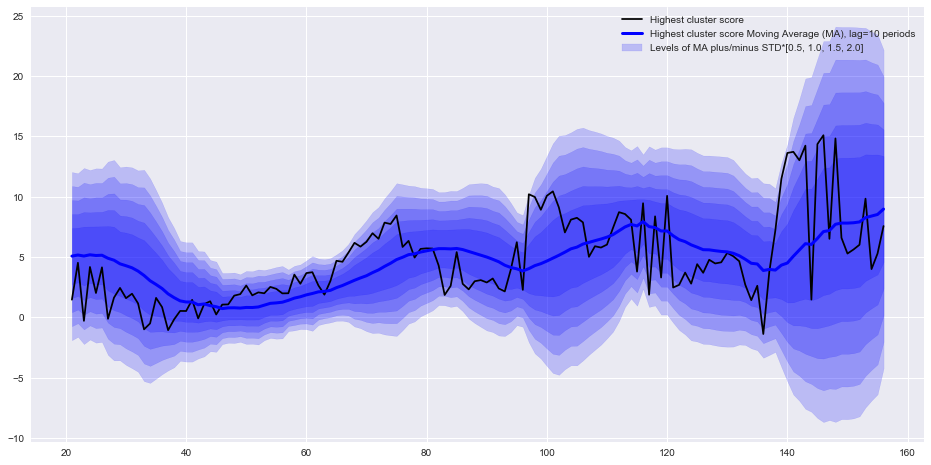

In [135]:
lag = MA_WIDTH
levels_sample = [1.0, 1.5, 2.0, 2.5, 3.0]

index = intervals.t_to[MA_WIDTH+1:].index
score = scores.score[MA_WIDTH+1:]
ma = ma_f('score', lag)[MA_WIDTH+1:]
mstd = mstd_f('score', lag)[MA_WIDTH+1:]

plt.figure(figsize=(16,8))
plt.plot(index, score, 'k')
plt.plot(index, ma, 'b', linewidth=3.0)
for level in levels_sample:
    plt.fill_between(index,
            ma - level * mstd,
            ma + level * mstd, color='b', alpha=0.2)
plt.legend(['Highest cluster score', 'Highest cluster score Moving Average (MA), lag=10 periods',
            'Levels of MA plus/minus STD*[0.5, 1.0, 1.5, 2.0]'])

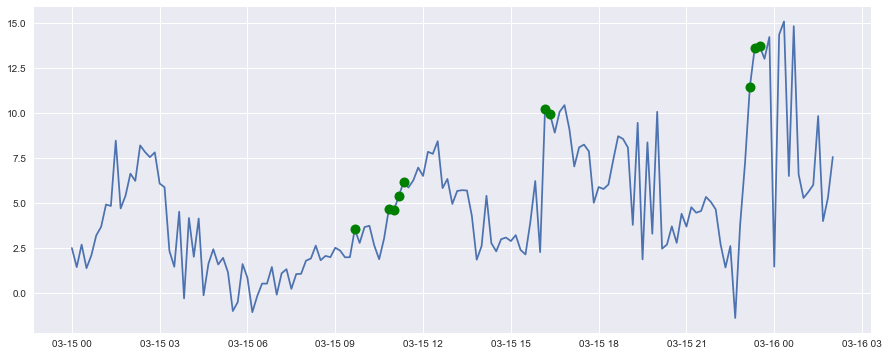

In [136]:
plt.figure(figsize=(15,6))
plt.plot(intervals.t_to, scores.score)

signal = (score > (ma + 2.0 * mstd))*1
signal.loc[signal < 1] = np.nan
signal = signal * scores.score - 0.0000
plt.plot(intervals.t_to, signal, 'og', markersize=10)

## Don't run below, it's just a 'screenshots' now

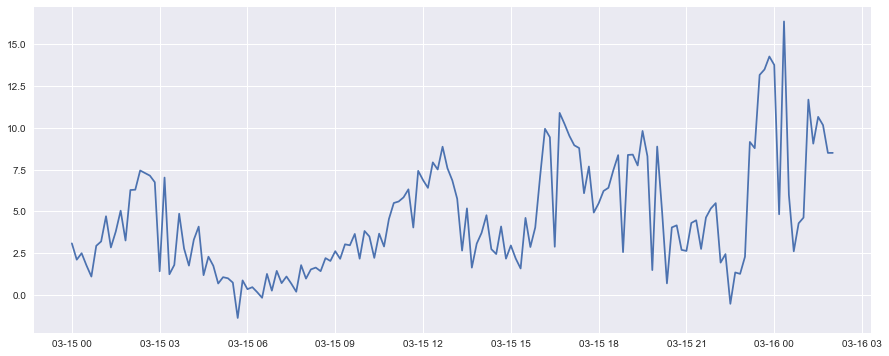

In [231]:
plt.figure(figsize=(15,6))
plt.plot(intervals.t_to, scores)

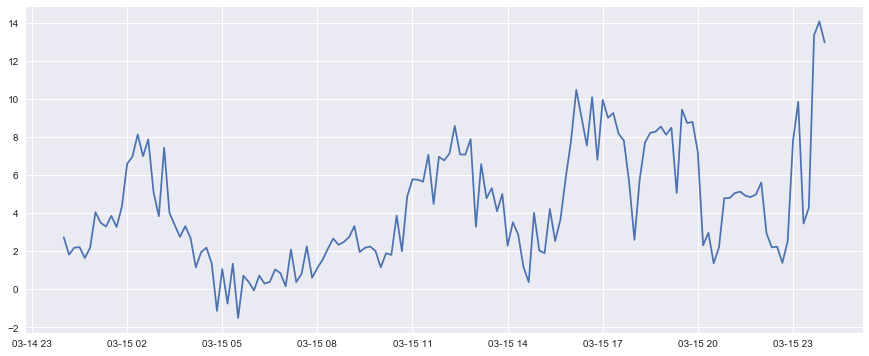

In [228]:
plt.figure(figsize=(15,6))
plt.plot(intervals.t_to, scores)

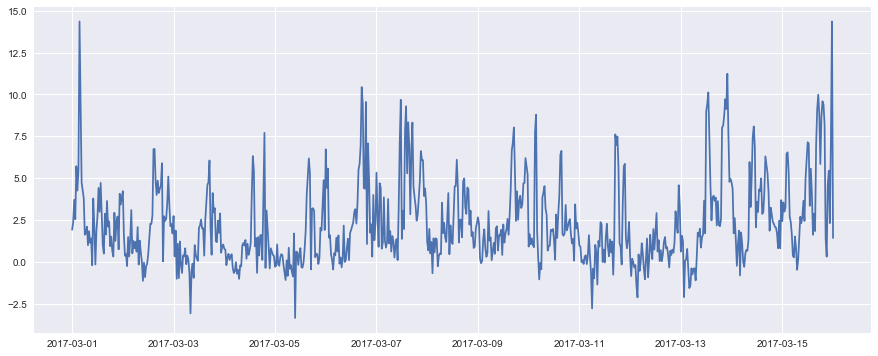

In [222]:
plt.figure(figsize=(15,6))
plt.plot(intervals.t_to, scores)

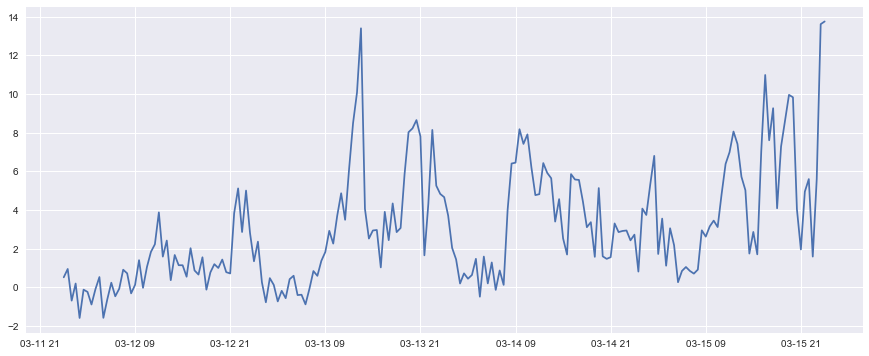

In [203]:
plt.figure(figsize=(15,6))
plt.plot(intervals.t_to, scores)

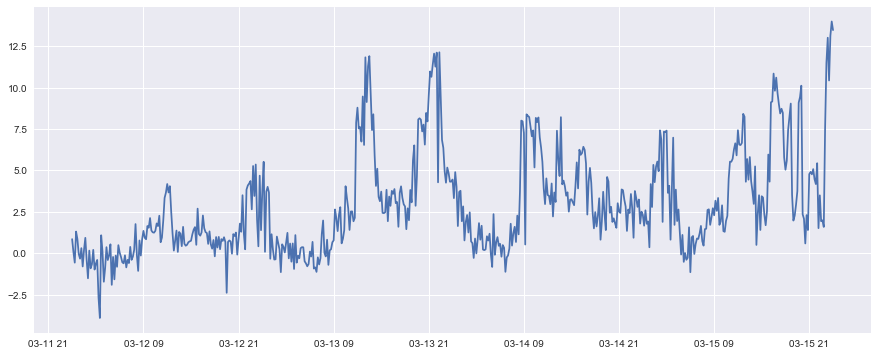

In [189]:
plt.figure(figsize=(15,6))
plt.plot(intervals.t_to, scores)

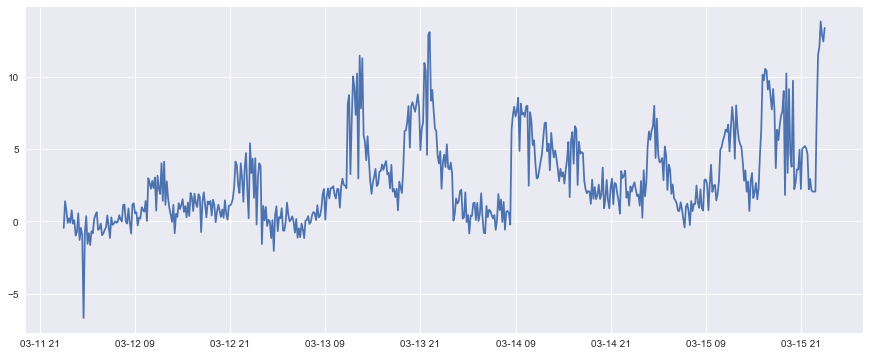

In [186]:
plt.figure(figsize=(15,6))
plt.plot(intervals.t_to, scores)